# Run GLM per time bin along trial

In [6]:
%load_ext autoreload
%autoreload 2
from capuchin import compute_accuracy, model_selection, plot_model_selection, plot_weights

import os, requests
import numpy as np

from scipy.stats import zscore
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
datapath = '/home/droumis/data/Steinmetz-2019/npz/'

fname = []
for j in range(3):
  fname.append(f'{datapath}steinmetz_part%d.npz'%j)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load(f'{datapath}steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [55]:
# use sessions 7 and 38
session = 38
dat = alldat[session]

area_idx = {}
# area_idx['VISp'] =  np.where([dat['brain_area'] == 'VISp'])[1]
area_idx['ILA'] =  np.where([dat['brain_area'] == 'ILA'])[1]
area_idx['PLA'] =  np.where([dat['brain_area'] == 'PL'])[1]
# area_idx['CA1'] =  np.where([dat['brain_area'] == 'CA1'])[1]
area_idx['MOs'] =  np.where([dat['brain_area'] == 'MOs'])[1]
area_idx['TH'] = np.where(np.isin(dat['brain_area'],
                                  ["CL", "LD", "LGd", "LH", "LP", "MD", 
                                   "MG", "PO", "POL", "PT", "RT", "SPF",
                                   "TH", "VAL", "VPL", "VPM"]))[0] # thalamus

response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(response)==np.sign(vis_left-vis_right)
go_nogo = response == 0

In [56]:
for a,n in area_idx.items():
    print(f'{a} : {len(n)}')

ILA : 187
PLA : 173
MOs : 54
TH : 59


In [57]:
go_nogo.sum()

110

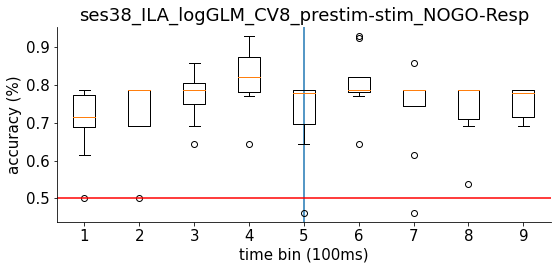

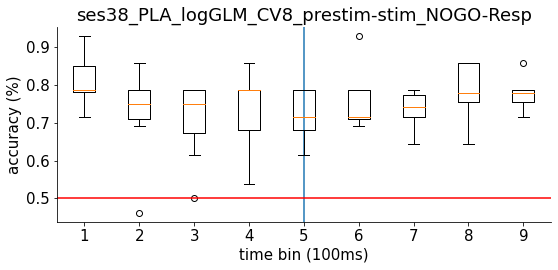

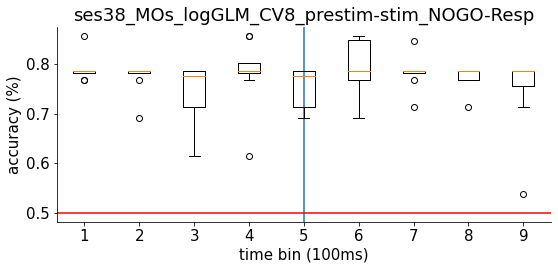

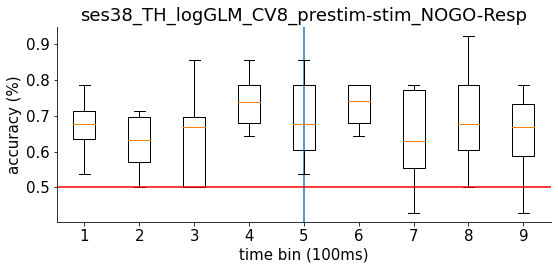

In [38]:
alldatz = np.nan_to_num(zscore(dat['spks'][:,go_nogo,:],0))
y = is_correct[go_nogo]
k = 8 # k fold CV
d = np.arange(0,91,10) # time bins in 10 ms increments.. 10 is 100 ms
startbins = d[:-1]
endbins = d[1:]

accuracies_all = {}
for barea,unit_idx_area in area_idx.items():
    # run GLM and CV
    accuracies_all[barea] = []
    for t,e in zip(startbins,endbins):
        X = np.mean(np.squeeze(alldatz[unit_idx_area,:,t:e]),-1).T
        accuracies = cross_val_score(LogisticRegression(penalty='l2'), X, y, cv=k)
        accuracies_all[barea].append(accuracies)

#     plot results
    f, ax = plt.subplots(figsize=(8, 4))
    plt.axvline(5)
    ax.boxplot(accuracies_all[barea], widths=.4)
    plt.axhline(.5, c='r')
    # ax.scatter(accuracies, np.ones(k))
    plt.ylabel('accuracy (%)')
    plt.xlabel('time bin (100ms)')
    tit = f'ses{session}_{barea}_logGLM_CV{k}_prestim-stim_NOGO-Resp'
    plt.title(tit)
    plt.savefig(f'/home/droumis/Src/capuchin/figures/{tit}.png', dpi=100, transparent=True)
    plt.savefig(f'/home/droumis/Src/capuchin/figures/{tit}.pdf')
    plt.show()